<a href="https://colab.research.google.com/github/abhinay-2006/RL/blob/main/SnakeGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install torch torchvision pillow --quiet
!pip install matplotlib imageio numpy seaborn --quiet

Imports and Configuration

In [12]:
import random
import numpy as np
from collections import deque, namedtuple
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageDraw, ImageFont
import imageio
import time
from IPython.display import display as ipydisp, Image as IPyImage
from typing import Tuple
Point = namedtuple('Point', 'x y')
class Direction(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3

Snake Environment (Game Logic + Rendering)

In [43]:
class SnakeEnv:
    def __init__(self, grid_size=25, block_size=20, max_steps=2000):
        self.grid_size = grid_size
        self.block_size = block_size
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.direction = Direction.RIGHT
        mid = self.grid_size // 2
        self.head = Point(mid, mid)
        self.snake = deque([
            self.head,
            Point(mid - 1, mid),
            Point(mid - 2, mid)
        ])
        self.place_food()
        self.frame_count = 0
        self.score = 0
        self.done = False
        return self._get_state()

    def place_food(self):
        while True:
            p = Point(random.randrange(0, self.grid_size), random.randrange(0, self.grid_size))
            if p not in self.snake:
                self.food = p
                break

    def step(self, action: int):
        if self.done:
            return self._get_state(), 0, True, {}

        self.direction = self._turn(self.direction, action)
        head = self._move(self.snake[0], self.direction)
        reward = 0
        self.frame_count += 1

        if self._is_collision(head):
            self.done = True
            reward = -10
            return self._get_state(), reward, True, {}

        self.snake.appendleft(head)

        if head == self.food:
            reward = 10
            self.score += 1
            self.place_food()
        else:
            self.snake.pop()
            reward += -0.1

        if self.frame_count > self.max_steps:
            self.done = True

        return self._get_state(), reward, self.done, {}

    def _is_collision(self, pt: Point):
        if not (0 <= pt.x < self.grid_size and 0 <= pt.y < self.grid_size):
            return True
        if pt in list(self.snake)[1:]:
            return True
        return False

    def _move(self, pt: Point, direction: Direction):
        if direction == Direction.RIGHT: return Point(pt.x + 1, pt.y)
        if direction == Direction.LEFT:  return Point(pt.x - 1, pt.y)
        if direction == Direction.UP:    return Point(pt.x, pt.y - 1)
        if direction == Direction.DOWN:  return Point(pt.x, pt.y + 1)

    def _turn(self, current: Direction, action: int):
        idx = current.value
        if action == 1:
            idx = (idx - 1) % 4
        elif action == 2:
            idx = (idx + 1) % 4
        return Direction(idx)

    def _get_state(self):
        head = self.snake[0]
        def danger_in_dir(dir_):
            nxt = self._move(head, dir_)
            return 1 if self._is_collision(nxt) else 0

        dir_idx = self.direction.value
        straight = Direction(dir_idx)
        left = Direction((dir_idx - 1) % 4)
        right = Direction((dir_idx + 1) % 4)
        danger_straight = danger_in_dir(straight)
        danger_left = danger_in_dir(left)
        danger_right = danger_in_dir(right)

        dir_onehot = [0, 0, 0, 0]
        dir_onehot[dir_idx] = 1

        food_left  = 1 if self.food.x < head.x else 0
        food_right = 1 if self.food.x > head.x else 0
        food_up    = 1 if self.food.y < head.y else 0
        food_down  = 1 if self.food.y > head.y else 0

        return np.array([danger_straight, danger_left, danger_right] + dir_onehot +
                        [food_left, food_right, food_up, food_down], dtype=float)

    def render_frame(self):
        gs, bs = self.grid_size, self.block_size
        H, W = gs * bs, gs * bs

        img = Image.new("RGB", (W, H), (230, 240, 250))
        draw = ImageDraw.Draw(img)

        for y in range(H):
            r = int(230 + 15 * y / H)
            g = int(240 + 7 * y / H)
            b = int(250 + 5 * y / H)
            draw.line([(0, y), (W, y)], fill=(r, g, b))

        grid_color = (220, 220, 235)
        for x in range(0, W, bs):
            draw.line([(x, 0), (x, H)], fill=grid_color)
        for y in range(0, H, bs):
            draw.line([(0, y), (W, y)], fill=grid_color)

        snake_list = list(self.snake)

        for p in snake_list[1:]:
            x0, y0 = p.x * bs, p.y * bs
            draw.rounded_rectangle([x0+2, y0+2, x0+bs-2, y0+bs-2], radius=bs//4, fill=(0, 180, 255), outline=(30, 90, 255), width=2)

        head = snake_list[0]
        x0, y0 = head.x * bs, head.y * bs
        draw.rounded_rectangle([x0+2, y0+2, x0+bs-2, y0+bs-2], radius=bs//3, fill=(255, 215, 0), outline=(250, 180, 60), width=2)
        eye_r = bs // 7
        draw.ellipse([x0+bs//3-eye_r, y0+bs//3-eye_r, x0+bs//3+eye_r, y0+bs//3+eye_r], fill=(0,0,0))
        draw.ellipse([x0+2*bs//3-eye_r, y0+bs//3-eye_r, x0+2*bs//3+eye_r, y0+bs//3+eye_r], fill=(0,0,0))

        fx, fy = self.food.x * bs, self.food.y * bs
        for g in range(8,0,-1):
            alpha = int(180 * (g/8))
            col = (255, 140+10*g, 0)
            draw.ellipse([fx-bs//4*g, fy-bs//4*g, fx+bs+bs//4*g, fy+bs+bs//4*g], fill=col)
        draw.rounded_rectangle([fx+2, fy+2, fx+bs-2, fy+bs-2], radius=bs//3, fill=(255, 90, 20), outline=(255, 203, 125), width=2)

        try:
            font = ImageFont.truetype("arial.ttf", bs)
        except:
            font = ImageFont.load_default()
        draw.text((7, 3), f"Score: {self.score}", fill=(30,30,30), font=font)

        return np.array(img)

DQN Network

In [23]:
class DQNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQNNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

Transition = namedtuple('Transition', ('state','action','next_state','reward','done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)


DQN Agent Definition

In [14]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, device='cpu'):
        self.device = device
        self.action_dim = action_dim
        self.policy_net = DQNNet(state_dim, 128, action_dim).to(device)
        self.target_net = DQNNet(state_dim, 128, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.replay = ReplayBuffer(20000)
        self.gamma = 0.99
        self.batch_size = 64
        self.update_target_every = 1000
        self.steps_done = 0

    def select_action(self, state, eps):
        self.steps_done += 1
        if random.random() < eps:
            return random.randrange(self.action_dim)
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            return int(torch.argmax(self.policy_net(s)).item())

    def push(self, *args):
        self.replay.push(*args)

    def train_step(self):
        if len(self.replay) < self.batch_size:
            return None
        trans = self.replay.sample(self.batch_size)
        states = torch.tensor(np.vstack(trans.state), dtype=torch.float32, device=self.device)
        actions = torch.tensor(trans.action, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(trans.reward, dtype=torch.float32, device=self.device).unsqueeze(1)
        dones = torch.tensor(trans.done, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.vstack(trans.next_state), dtype=torch.float32, device=self.device)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = nn.functional.mse_loss(q_values, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps_done % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        return loss.item()


Training Setup & Hyperparameters

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = SnakeEnv(grid_size=25, block_size=18, max_steps=2000)
state_dim = 3 + 4 + 4
action_dim = 3
agent = DQNAgent(state_dim, action_dim, device=device)

num_episodes = 350
eps_start, eps_end, eps_decay = 1.0, 0.05, 0.995

scores, losses = [], []
eps = eps_start
metrics = {k: [] for k in [
    "episode", "avg_reward", "cumulative_reward", "max_reward",
    "min_reward", "moving_avg", "avg_loss", "reward_std",
    "mean_q_value", "eps"
]}

def compute_moving_average(data, window=20):
    return np.mean(data[-window:]) if len(data) >= window else np.mean(data) if data else 0
print("Starting DQN Training with Metrics Collection...")


Starting DQN Training with Metrics Collection...


Training Loop with Metrics

Ep 020 | AvgScore(20): 0.05 | Eps 0.905 | Loss 0.0124 | Q -0.228
Ep 040 | AvgScore(20): 0.20 | Eps 0.818 | Loss 0.4794 | Q -0.064
Ep 060 | AvgScore(20): 0.30 | Eps 0.740 | Loss 0.5644 | Q 0.089
Ep 080 | AvgScore(20): 0.60 | Eps 0.670 | Loss 0.7231 | Q 0.180
Ep 100 | AvgScore(20): 1.05 | Eps 0.606 | Loss 0.8405 | Q 2.986
Ep 120 | AvgScore(20): 1.15 | Eps 0.548 | Loss 0.9216 | Q 2.318
Ep 140 | AvgScore(20): 1.20 | Eps 0.496 | Loss 1.1357 | Q 2.263
Ep 160 | AvgScore(20): 1.40 | Eps 0.448 | Loss 1.0837 | Q 4.094
Ep 180 | AvgScore(20): 1.65 | Eps 0.406 | Loss 1.1315 | Q 4.537
Ep 200 | AvgScore(20): 2.55 | Eps 0.367 | Loss 1.3909 | Q 3.210
Ep 220 | AvgScore(20): 2.20 | Eps 0.332 | Loss 1.8211 | Q 5.277
Ep 240 | AvgScore(20): 2.55 | Eps 0.300 | Loss 1.7662 | Q 7.096
Ep 260 | AvgScore(20): 2.45 | Eps 0.272 | Loss 1.6739 | Q 5.554
Ep 280 | AvgScore(20): 3.45 | Eps 0.246 | Loss 2.1230 | Q 6.513
Ep 300 | AvgScore(20): 3.70 | Eps 0.222 | Loss 2.3646 | Q 8.510
Ep 320 | AvgScore(20): 3.10 | Eps 0.20

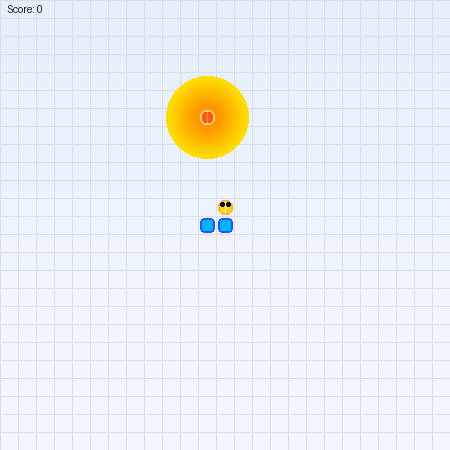


✓ Gameplay GIF saved: snake_play.gif


In [37]:
for ep in range(1, num_episodes + 1):
    state = env.reset()
    total_reward = 0
    done = False
    q_values_episode = []
    start_time = time.time()

    while not done:
        action = agent.select_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.push(state, action, next_state, reward, float(done))
        loss = agent.train_step()
        if loss: losses.append(loss)

        with torch.no_grad():
            q_values_episode.append(agent.policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).mean().item())

        state = next_state
        total_reward += reward

    scores.append(env.score)
    eps = max(eps_end, eps * eps_decay)

    metrics["episode"].append(ep)
    metrics["avg_reward"].append(total_reward)
    metrics["cumulative_reward"].append(np.sum(scores))
    metrics["max_reward"].append(np.max(scores))
    metrics["min_reward"].append(np.min(scores))
    metrics["moving_avg"].append(compute_moving_average(scores))
    metrics["avg_loss"].append(np.mean(losses[-200:]) if losses else 0)
    metrics["reward_std"].append(np.std(scores[-20:]) if len(scores) >= 20 else 0)
    metrics["mean_q_value"].append(np.mean(q_values_episode))
    metrics["eps"].append(eps)

    if ep % 20 == 0:
        print(f"Ep {ep:03d} | AvgScore(20): {metrics['moving_avg'][-1]:.2f} | Eps {eps:.3f} | "
              f"Loss {metrics['avg_loss'][-1]:.4f} | Q {metrics['mean_q_value'][-1]:.3f}")

torch.save(agent.policy_net.state_dict(), "dqn_snake.pth")
print("\n✓ Model saved as dqn_snake.pth")
def play_and_record(agent, env, n_steps=700, eps=0.0, fname="snake_play.gif"):
    frames = []
    state = env.reset()
    done = False
    steps = 0
    while not done and steps < n_steps:
        action = agent.select_action(state, eps)
        state, _, done, _ = env.step(action)
        frames.append(env.render_frame())
        steps += 1
    imageio.mimsave(fname, frames, fps=12)
    return fname

print("\nGenerating gameplay demonstration...")
gif_path = play_and_record(agent, env)
ipydisp(IPyImage(filename=gif_path))
print(f"\n✓ Gameplay GIF saved: {gif_path}")


Evaluation and Visualization

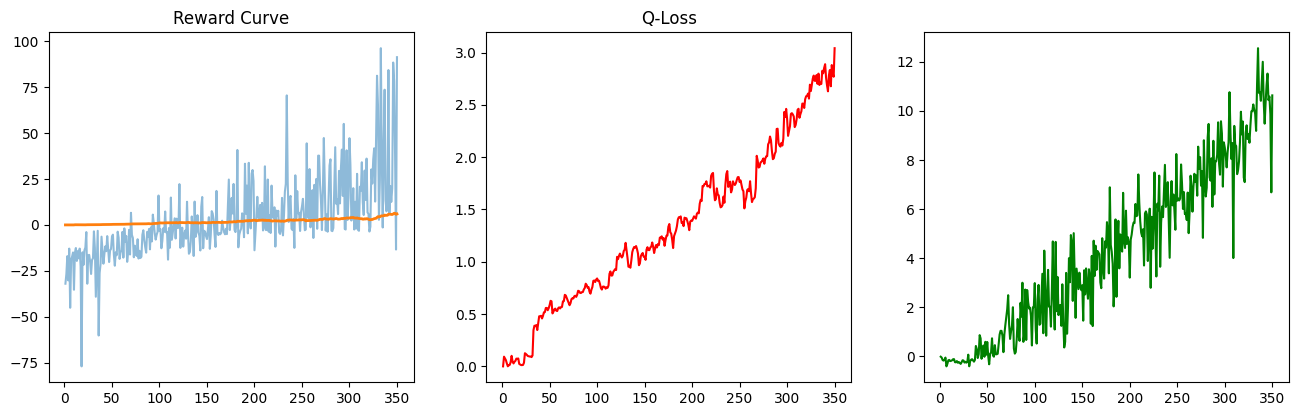

In [41]:
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.plot(metrics["episode"], metrics["avg_reward"], alpha=0.5)
plt.plot(metrics["episode"], metrics["moving_avg"], linewidth=2)
plt.title("Reward Curve")
plt.subplot(2,3,2)
plt.plot(metrics["episode"], metrics["avg_loss"], color='red')
plt.title("Q-Loss")
plt.subplot(2,3,3)
plt.plot(metrics["episode"], metrics["mean_q_value"], color='green')


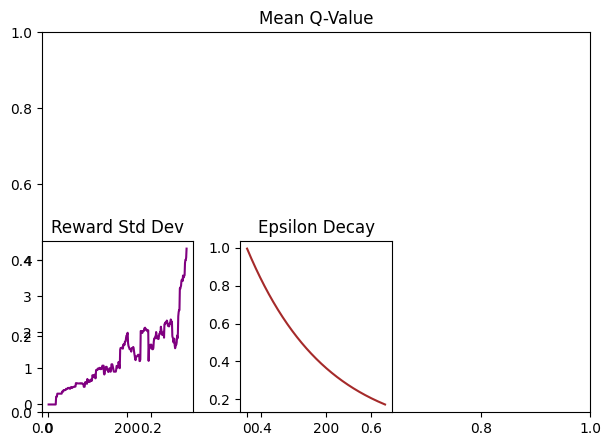

In [42]:
plt.title("Mean Q-Value")
plt.subplot(2,3,4)
plt.plot(metrics["episode"], metrics["reward_std"], color='purple')
plt.title("Reward Std Dev")
plt.subplot(2,3,5)
plt.plot(metrics["episode"], metrics["eps"], color='brown')
plt.title("Epsilon Decay")

plt.tight_layout()
plt.show()
action_counts = [0, 0, 0]
test_env = SnakeEnv()
for _ in range(1000):
    state = test_env._get_state()
    a = agent.select_action(state, eps=0.0)
    action_counts[a] += 1
    _, _, done, _ = test_env.step(a)
    if done: test_env.reset()

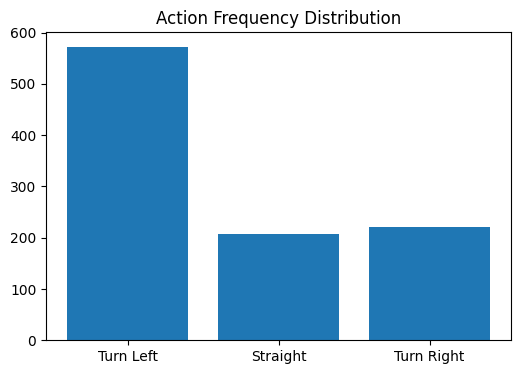

In [39]:
plt.figure(figsize=(6,4))
plt.bar(["Turn Left", "Straight", "Turn Right"], action_counts)
plt.title("Action Frequency Distribution")
plt.show()

In [40]:
print("\nTraining Summary:")
print(f"Final Avg Score: {metrics['moving_avg'][-1]:.2f}")
print(f"Max Score: {metrics['max_reward'][-1]}")
print(f"Final Avg Loss: {metrics['avg_loss'][-1]:.4f}")
print(f"Final Epsilon: {metrics['eps'][-1]:.3f}")


Training Summary:
Final Avg Score: 5.95
Max Score: 13
Final Avg Loss: 3.0422
Final Epsilon: 0.173
